<a href="https://colab.research.google.com/github/saiyuu330/COSE474_Project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeungyun","key":"2d6b19b1c261f1452c200ad28d1f5208"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d nqa112/vietnamese-bike-and-motorbike

100% 1.44G/1.44G [00:37<00:00, 45.4MB/s]
100% 1.44G/1.44G [00:37<00:00, 41.4MB/s]


In [4]:
!unzip -o -q /content/vietnamese-bike-and-motorbike.zip -d /content/data

In [5]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from PIL import Image
from struct import unpack
import pathlib

In [6]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break

In [7]:
def delete_corrupted_image(image):
    if str(image).endswith("gif"):
      return image
    else:
      check = JPEG(image)
      try:
        check.decode()
      except:
        return image

In [8]:
data_dir = pathlib.Path("/content/data")

for image in data_dir.glob("*/*"):
  corrupt = delete_corrupted_image(image)
  if corrupt is not None:
    print(f"Delete {image}")
    image.unlink()

Delete /content/data/motorbike/Motorlccwyb8ksmallMotor.jpg
Delete /content/data/motorbike/70_a2_1_1568719423160_11994.jpg
Delete /content/data/motorbike/93_honda_airblade_2014_1568719129105_7903.jpg
Delete /content/data/motorbike/79_414925055008472_1568719726002_16213.jpg
Delete /content/data/motorbike/55_gia_xe_81_2_1568719088201_7338.gif
Delete /content/data/motorbike/Motor7svrb_zvsmallMotor.jpg
Delete /content/data/motorbike/65_51ew43mofl9ef_1568719232558_9326.gif
Delete /content/data/motorbike/36_1498933419_1568719566728_14016.jpg
Delete /content/data/motorbike/19_r_636858959614681208_4528_kkk_1568719429934_12092.gif
Delete /content/data/motorbike/69_xedoisong_Yamaha_MT_03_do_1_MEGC_1568719472292_12693.gif
Delete /content/data/motorbike/96_gia_xe_may_sym_re_nhat_2016_duoc_nguoi_tieu_dung_ua_chuong_4_1568719337886_10799.jpg
Delete /content/data/motorbike/2019_08_05_05_17_32_B0xS_6hHgXG_66398352_483445189138958_8195470045202604419_n_1568719912383_18787.jpg
Delete /content/data/motorb

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="/content/data", transform=transform)

In [15]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

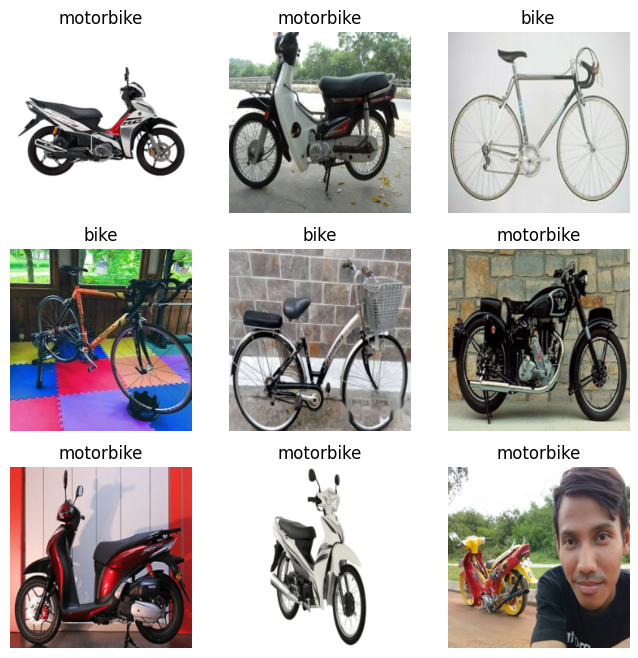

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    img = img.numpy().transpose((1, 2, 0))

    class_name = dataset.classes[label]
    ax.set_title(class_name)
    ax.imshow(img)
    ax.axis("off")

plt.show()

In [16]:
def add_gaussian_noise(image, mean=0, std=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, std, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255)
    return noisy_image.astype(np.uint8)

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=25):
        self.mean = mean
        self.std = std
    def __call__(self, img):
        img_array = np.array(img)
        noisy_img_array = add_gaussian_noise(img_array, mean=self.mean, std=self.std)
        noisy_img = Image.fromarray(noisy_img_array)
        return noisy_img

In [18]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    AddGaussianNoise(mean=0, std=50),
    transforms.ToTensor(),
])

noise_dataset = datasets.ImageFolder(root="/content/data", transform=transform)

In [19]:
dataset_size = len(noise_dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(noise_dataset, [train_size, validation_size, test_size])

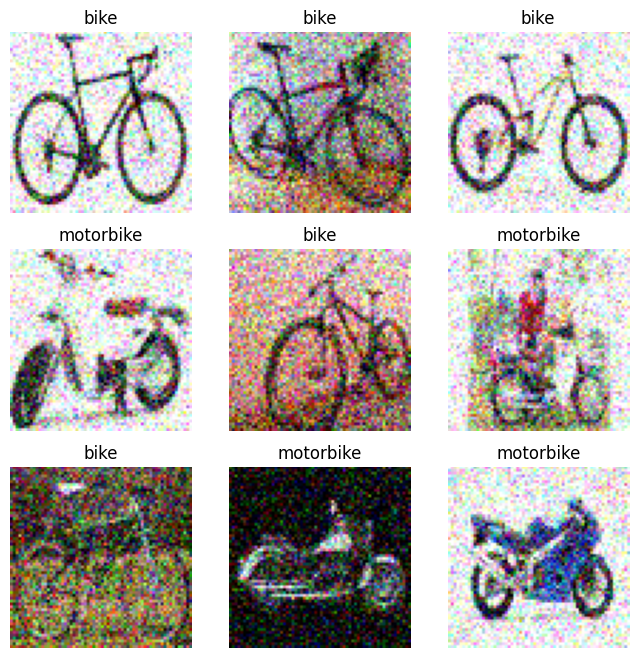

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]

    img = img.numpy().transpose((1, 2, 0))

    class_name = noise_dataset.classes[label]
    ax.set_title(class_name)
    ax.imshow(img)
    ax.axis("off")

plt.show()

In [22]:
noise_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = models.vgg16()

num_classes = len(noise_dataset.classes)
model.classifier[6] = nn.Linear(4096, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model = model.to(device)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 0.6533496241168221
Epoch 2/5, Loss: 0.40379870459191475
Epoch 3/5, Loss: 0.30632835164321925
Epoch 4/5, Loss: 0.2719274792488259
Epoch 5/5, Loss: 0.24128940424854212


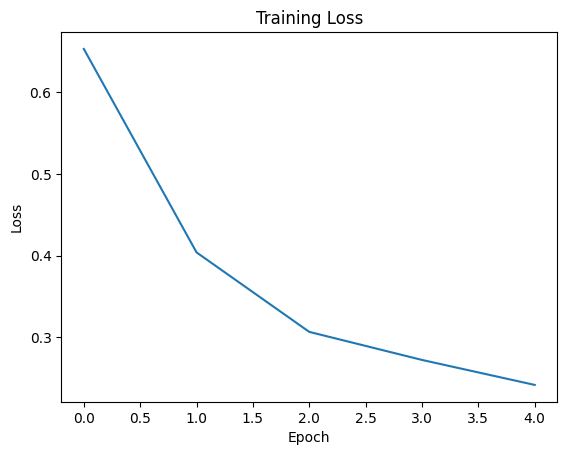

In [23]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in noise_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(noise_data_loader)
    losses.append(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


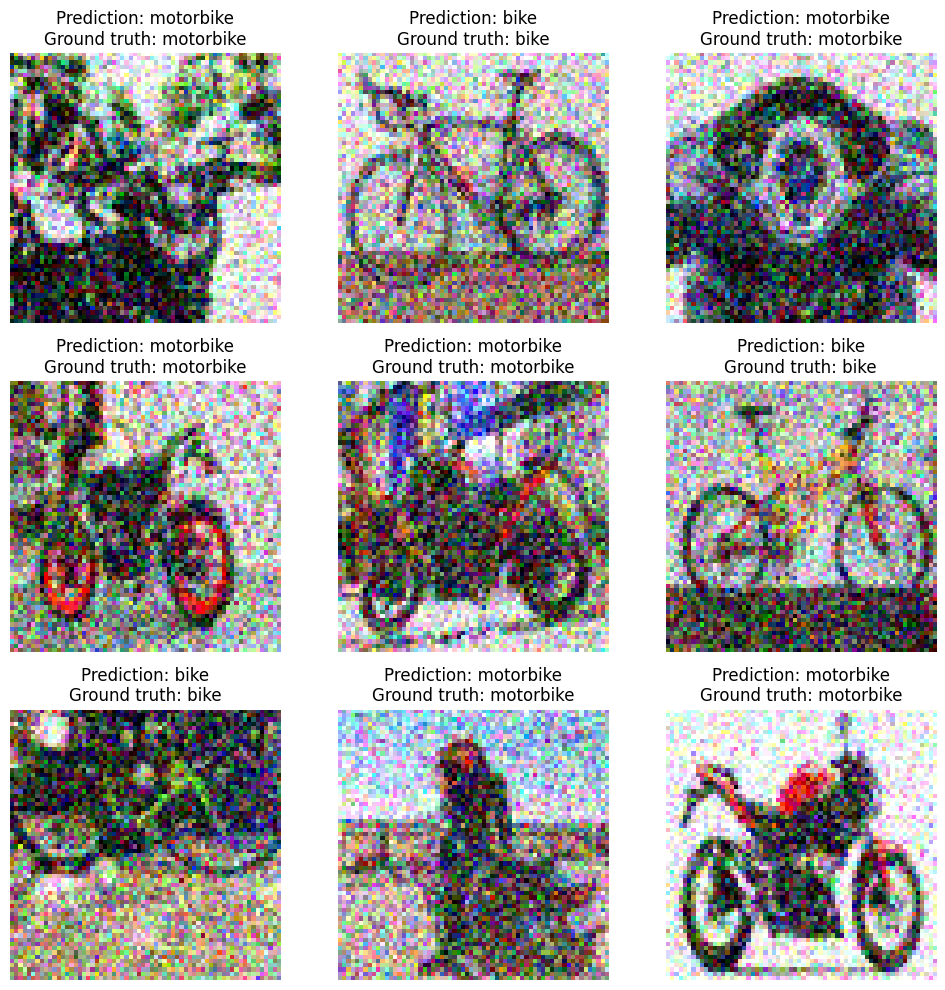

In [25]:
model.eval()

with torch.no_grad():
    sample_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=9, sampler=torch.utils.data.SubsetRandomSampler(range(len(validation_dataset))))

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for (inputs, labels), ax in zip(sample_loader, axes.flatten()):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        class_names = [noise_dataset.classes[i] for i in preds]
        ground_truth = [noise_dataset.classes[i] for i in labels]

        for i, ax in enumerate(axes.flatten()):
            img = transforms.ToPILImage()(inputs[i].cpu())
            ax.imshow(img)
            ax.set_title(f"Prediction: {class_names[i]}\nGround truth: {ground_truth[i]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

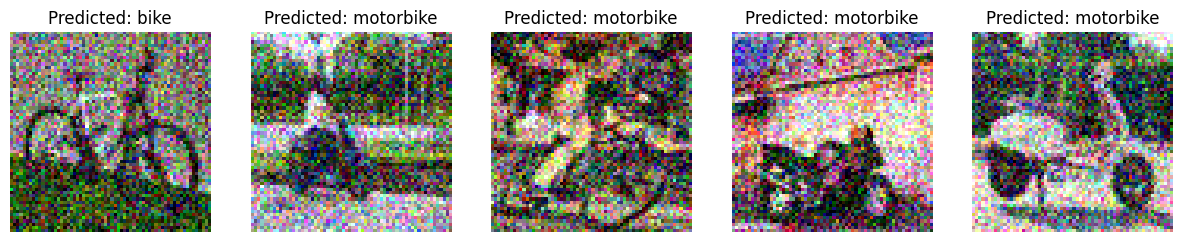

In [28]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    index = i
    img, _ = test_dataset[index]
    img = img.to(device)
    img = img.unsqueeze(0)
    img = img.to(device)

    output = model(img)
    _, predicted_label = torch.max(output.data, 1)
    predicted_class = noise_dataset.classes[predicted_label.item()]

    img = img.cpu()

    axes[i].imshow(img.squeeze().permute(1, 2, 0))
    axes[i].set_title(f'Predicted: {predicted_class}')
    axes[i].axis('off')

plt.show()
